### Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import nltk
from nltk import *
from keras_bert import extract_embeddings
import h5py
import time
import os

Using TensorFlow backend.


### Read note events and diagnose icd's of the patients 

In [2]:
NOTE_EVENTS_FILE = "/home/girish/physionet.org/files/mimiciii/1.4/NOTEEVENTS.csv.gz"
note_events = pd.read_csv(NOTE_EVENTS_FILE, compression='gzip')

print("Number of columns: ", note_events.shape[1])
print("Note Events Shape: ", note_events.shape)

note_events.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of columns:  11
Note Events Shape:  (2083180, 11)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [3]:
DIAGNOSE_ICD_FILE = "/home/girish/physionet.org/files/mimiciii/1.4/DIAGNOSES_ICD.csv.gz"

diagnose_icd = pd.read_csv(DIAGNOSE_ICD_FILE, compression='gzip')

print("Number of columns: ", diagnose_icd.shape[1])
print("Note Events Shape: ", diagnose_icd.shape)

diagnose_icd.head()

Number of columns:  5
Note Events Shape:  (651047, 5)


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


### Select diseases by ICD codes to filter

In [4]:
# diseases = {'Urinary Tract Infection': '5990', 'Thrombocytopenia': '2875', 'Pneumonia': '486', 'Asthma': '49390', 'Rheumatoid Arthritis': '7140', 'Cardiac Arrest': '4275', 'Anemia': '2859', 'Pulmonary Hypertension': '4160', 'Acute Resp. Failure': '51881'}
diseases = {'Pneumonia': '486', 'Acute Resp. Failure': '51881'}

X = []
y = []
count = 0
errors = 0

for i in range(len(diagnose_icd)):
    count += 1
    if(count % 500 == 0):
        print(count, len(y))
#     if(count == 100000):
#         break
    if((diagnose_icd["ICD9_CODE"][i] in list(diseases.values())) and (diagnose_icd["SEQ_NUM"][i] == 1.0)):
        try:
            X.append(note_events.loc[(note_events["SUBJECT_ID"] == diagnose_icd["SUBJECT_ID"][i]) & (note_events["HADM_ID"] == diagnose_icd["HADM_ID"][i]) & (note_events["CATEGORY"] == "Discharge summary")]["TEXT"].values[0])
            y.append(diagnose_icd["ICD9_CODE"][i])
        except:
            print("Error", errors)
            errors += 1

500 0
1000 1
1500 1
2000 3
2500 3
3000 4
3500 5
4000 5
4500 7
5000 9
5500 10
Error 0
6000 12
6500 14
7000 17
7500 20
8000 21
8500 22
9000 23
9500 24
10000 25
10500 26
11000 29
11500 30
12000 30
12500 32
13000 33
13500 36
14000 40
14500 41
15000 41
15500 42
16000 43
16500 43
17000 46
17500 46
18000 47
18500 47
19000 48
19500 51
20000 52
20500 55
21000 57
21500 59
22000 59
22500 60
23000 62
23500 68
24000 69
24500 70
25000 72
25500 73
26000 75
26500 76
27000 78
27500 79
28000 82
28500 87
29000 90
29500 93
30000 95
30500 95
31000 97
31500 98
32000 99
32500 102
33000 105
33500 106
34000 108
34500 110
35000 110
35500 114
Error 1
36000 116
36500 117
37000 117
37500 118
38000 118
38500 120
39000 122
Error 2
39500 122
40000 124
40500 124
41000 127
41500 129
42000 129
42500 130
43000 131
43500 133
44000 135
44500 138
45000 139
45500 140
46000 144
46500 145
47000 146
47500 148
Error 3
48000 149
48500 151
49000 154
49500 155
50000 156
Error 4
50500 157
51000 161
51500 163
52000 163
52500 163
5300

Error 37
367000 1179
367500 1179
368000 1180
368500 1183
369000 1183
369500 1183
370000 1185
370500 1185
371000 1187
371500 1189
372000 1190
372500 1191
373000 1193
373500 1194
374000 1197
374500 1201
375000 1204
375500 1204
376000 1205
376500 1207
377000 1207
377500 1209
378000 1209
378500 1212
379000 1213
379500 1213
380000 1214
380500 1214
381000 1216
381500 1217
382000 1217
382500 1217
383000 1219
383500 1220
384000 1220
384500 1223
385000 1223
385500 1223
386000 1224
386500 1225
387000 1225
387500 1226
388000 1228
388500 1228
389000 1229
389500 1230
390000 1231
390500 1233
391000 1235
391500 1235
392000 1236
392500 1237
393000 1237
393500 1237
394000 1239
394500 1241
395000 1243
395500 1243
396000 1244
396500 1245
397000 1245
397500 1246
398000 1251
Error 38
398500 1251
399000 1254
399500 1254
400000 1255
400500 1255
401000 1255
401500 1258
402000 1260
402500 1261
403000 1262
403500 1263
404000 1264
404500 1264
405000 1265
405500 1266
406000 1267
406500 1269
407000 1270
407500 127

In [5]:
X = np.array(X)
y = np.array(y)

print("Shape of X: ", X.shape)
print("shape of y: ", y.shape)

Shape of X:  (1792,)
shape of y:  (1792,)


### Load the dataset

In [6]:
AFTER_CANCER_PATH = "/home/chennuri/CliNER/aft_canc_mod/"
BEFORE_CANCER_PATH = "/home/chennuri/CliNER/bef_canc_mod/"
NO_CANCER_PATH = "/home/chennuri/CliNER/no_canc_mod/"

X_bef_problems_files = os.listdir(BEFORE_CANCER_PATH)
X_no_problems_files = os.listdir(NO_CANCER_PATH)

X_before_cancer_problems = np.array([open(BEFORE_CANCER_PATH + file, 'r').read() for file in X_bef_problems_files])
X_after_cancer_problems = np.array([open(AFTER_CANCER_PATH + file, 'r').read() for file in os.listdir(AFTER_CANCER_PATH)])
X_no_cancer_problems_1 = np.array([open(NO_CANCER_PATH + file, 'r').read() for file in X_no_problems_files])[:X_before_cancer_problems.shape[0]]
X_no_cancer_problems_2 = np.array([open(NO_CANCER_PATH + file, 'r').read() for file in X_no_problems_files])[X_before_cancer_problems.shape[0]:X_before_cancer_problems.shape[0]*2]
X_no_cancer_problems_3 = np.array([open(NO_CANCER_PATH + file, 'r').read() for file in X_no_problems_files])[X_before_cancer_problems.shape[0]*2:X_before_cancer_problems.shape[0]*3]
X_no_cancer_problems_4 = np.array([open(NO_CANCER_PATH + file, 'r').read() for file in X_no_problems_files])[X_before_cancer_problems.shape[0]*3:X_before_cancer_problems.shape[0]*4]
X_no_cancer_problems_5 = np.array([open(NO_CANCER_PATH + file, 'r').read() for file in X_no_problems_files])[X_before_cancer_problems.shape[0]*4:X_before_cancer_problems.shape[0]*5]


print("Shape of X_before_cancer_problems:", X_before_cancer_problems.shape)
print("Shape of X_after_cancer_problems:", X_after_cancer_problems.shape)
print("Shape of X_no_cancer_problems_1:", X_no_cancer_problems_1.shape)
print("Shape of X_no_cancer_problems_2:", X_no_cancer_problems_2.shape)
print("Shape of X_no_cancer_problems_3:", X_no_cancer_problems_3.shape)
print("Shape of X_no_cancer_problems_4:", X_no_cancer_problems_4.shape)
print("Shape of X_no_cancer_problems_5:", X_no_cancer_problems_5.shape)

y_before_cancer = np.zeros(X_before_cancer_problems.shape[0])
y_after_cancer = np.zeros(X_after_cancer_problems.shape[0])
y_no_cancer = np.ones(X_no_cancer_problems_1.shape[0])

Shape of X_before_cancer_problems: (1917,)
Shape of X_after_cancer_problems: (9546,)
Shape of X_no_cancer_problems_1: (1917,)
Shape of X_no_cancer_problems_2: (1917,)
Shape of X_no_cancer_problems_3: (1917,)
Shape of X_no_cancer_problems_4: (1917,)
Shape of X_no_cancer_problems_5: (1917,)


In [54]:
AFTER_CANCER_PATH = "/home/chennuri/CliNER/aft_canc_mod_tests/"
BEFORE_CANCER_PATH = "/home/chennuri/CliNER/bef_canc_mod_tests/"
NO_CANCER_PATH = "/home/chennuri/CliNER/no_canc_mod_tests/"

X_bef_tests_files = os.listdir(BEFORE_CANCER_PATH)
X_no_tests_files = os.listdir(NO_CANCER_PATH)

X_before_cancer_tests = np.array([open(BEFORE_CANCER_PATH + file, 'r').read() for file in X_bef_tests_files])
X_after_cancer_tests = np.array([open(AFTER_CANCER_PATH + file, 'r').read() for file in os.listdir(AFTER_CANCER_PATH)])
X_no_cancer_tests_1 = np.array([open(NO_CANCER_PATH + file, 'r').read() for file in X_no_tests_files])[:X_before_cancer_tests.shape[0]]
X_no_cancer_tests_2 = np.array([open(NO_CANCER_PATH + file, 'r').read() for file in X_no_tests_files])[X_before_cancer_tests.shape[0]:X_before_cancer_tests.shape[0]*2]
X_no_cancer_tests_3 = np.array([open(NO_CANCER_PATH + file, 'r').read() for file in X_no_tests_files])[X_before_cancer_tests.shape[0]*2:X_before_cancer_tests.shape[0]*3]
X_no_cancer_tests_4 = np.array([open(NO_CANCER_PATH + file, 'r').read() for file in X_no_tests_files])[X_before_cancer_tests.shape[0]*3:X_before_cancer_tests.shape[0]*4]
X_no_cancer_tests_5 = np.array([open(NO_CANCER_PATH + file, 'r').read() for file in X_no_tests_files])[X_before_cancer_tests.shape[0]*4:X_before_cancer_tests.shape[0]*5]


print("Shape of X_before_cancer_tests:", X_before_cancer_tests.shape)
print("Shape of X_after_cancer_tests:", X_after_cancer_tests.shape)
print("Shape of X_no_cancer_tests_1:", X_no_cancer_tests_1.shape)
print("Shape of X_no_cancer_tests_2:", X_no_cancer_tests_2.shape)
print("Shape of X_no_cancer_tests_3:", X_no_cancer_tests_3.shape)
print("Shape of X_no_cancer_tests_4:", X_no_cancer_tests_4.shape)
print("Shape of X_no_cancer_tests_5:", X_no_cancer_tests_5.shape)

y_before_cancer = np.zeros(X_before_cancer_tests.shape[0])
y_after_cancer = np.zeros(X_after_cancer_tests.shape[0])
y_no_cancer = np.ones(X_no_cancer_tests_1.shape[0])

Shape of X_before_cancer_tests: (1917,)
Shape of X_after_cancer_tests: (9546,)
Shape of X_no_cancer_tests_1: (1917,)
Shape of X_no_cancer_tests_2: (1917,)
Shape of X_no_cancer_tests_3: (1917,)
Shape of X_no_cancer_tests_4: (1917,)
Shape of X_no_cancer_tests_5: (1917,)


In [7]:
AFTER_CANCER_PATH = "/home/chennuri/CliNER/aft_canc_mod_treatments/"
BEFORE_CANCER_PATH = "/home/chennuri/CliNER/bef_canc_mod_treatments/"
NO_CANCER_PATH = "/home/chennuri/CliNER/no_canc_mod_treatments/"

X_bef_treatments_files = os.listdir(BEFORE_CANCER_PATH)
X_no_treatments_files = os.listdir(NO_CANCER_PATH)

X_before_cancer_treatments = np.array([open(BEFORE_CANCER_PATH + file, 'r').read() for file in X_bef_treatments_files])
X_after_cancer_treatments = np.array([open(AFTER_CANCER_PATH + file, 'r').read() for file in os.listdir(AFTER_CANCER_PATH)])
X_no_cancer_treatments_1 = np.array([open(NO_CANCER_PATH + file, 'r').read() for file in X_no_treatments_files])[:X_before_cancer_treatments.shape[0]]
X_no_cancer_treatments_2 = np.array([open(NO_CANCER_PATH + file, 'r').read() for file in X_no_treatments_files])[X_before_cancer_treatments.shape[0]:X_before_cancer_treatments.shape[0]*2]
X_no_cancer_treatments_3 = np.array([open(NO_CANCER_PATH + file, 'r').read() for file in X_no_treatments_files])[X_before_cancer_treatments.shape[0]*2:X_before_cancer_treatments.shape[0]*3]
X_no_cancer_treatments_4 = np.array([open(NO_CANCER_PATH + file, 'r').read() for file in X_no_treatments_files])[X_before_cancer_treatments.shape[0]*3:X_before_cancer_treatments.shape[0]*4]
X_no_cancer_treatments_5 = np.array([open(NO_CANCER_PATH + file, 'r').read() for file in X_no_treatments_files])[X_before_cancer_treatments.shape[0]*4:X_before_cancer_treatments.shape[0]*5]

print("Shape of X_before_cancer_treatments:", X_before_cancer_treatments.shape)
print("Shape of X_after_cancer_treatments:", X_after_cancer_treatments.shape)
print("Shape of X_no_cancer_treatments_1:", X_no_cancer_treatments_1.shape)
print("Shape of X_no_cancer_treatments_2:", X_no_cancer_treatments_2.shape)
print("Shape of X_no_cancer_treatments_3:", X_no_cancer_treatments_3.shape)
print("Shape of X_no_cancer_treatments_4:", X_no_cancer_treatments_4.shape)
print("Shape of X_no_cancer_treatments_5:", X_no_cancer_treatments_5.shape)

Shape of X_before_cancer_treatments: (1917,)
Shape of X_after_cancer_treatments: (9546,)
Shape of X_no_cancer_treatments_1: (1917,)
Shape of X_no_cancer_treatments_2: (1917,)
Shape of X_no_cancer_treatments_3: (1917,)
Shape of X_no_cancer_treatments_4: (1917,)
Shape of X_no_cancer_treatments_5: (1917,)


In [8]:
len(X_no_treatments_files)

11216

### Get Bert Embeddings

In [9]:
MODEL_PATH = '/home/gowtham/.keras/datasets/multi_cased_L-12_H-768_A-12'
BIO_BERT_PATH = '/home/gowtham/biobert_v1.1_pubmed'

# current = time.time()
# after_cancer_embeddings = np.array(extract_embeddings(BIO_BERT_PATH, X_after_cancer_files))
# after_cancer_embeddings = np.array([np.mean(i, axis = 0) for i in after_cancer_embeddings])
# future = time.time()
# print("Time taken: ", future - current)
# print("Embeddings shape: ", after_cancer_embeddings.shape)

current = time.time()
before_cancer_problems_embedding = np.array(extract_embeddings(BIO_BERT_PATH, X_before_cancer_problems))
before_cancer_problems_embeddings = np.array([np.mean(i, axis = 0) for i in before_cancer_problems_embedding])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", before_cancer_problems_embeddings.shape)

current = time.time()
no_cancer_problems_embeddings_1 = np.array(extract_embeddings(BIO_BERT_PATH, X_no_cancer_problems_1))
no_cancer_problems_embeddings_1 = np.array([np.mean(i, axis = 0) for i in no_cancer_problems_embeddings_1])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", no_cancer_problems_embeddings_1.shape)

current = time.time()
no_cancer_problems_embeddings_2 = np.array(extract_embeddings(BIO_BERT_PATH, X_no_cancer_problems_2))
no_cancer_problems_embeddings_2 = np.array([np.mean(i, axis = 0) for i in no_cancer_problems_embeddings_2])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", no_cancer_problems_embeddings_2.shape)

current = time.time()
no_cancer_problems_embeddings_4 = np.array(extract_embeddings(BIO_BERT_PATH, X_no_cancer_problems_4))
no_cancer_problems_embeddings_4 = np.array([np.mean(i, axis = 0) for i in no_cancer_problems_embeddings_4])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", no_cancer_problems_embeddings_4.shape)

current = time.time()
no_cancer_problems_embeddings_3 = np.array(extract_embeddings(BIO_BERT_PATH, X_no_cancer_problems_3))
no_cancer_problems_embeddings_3 = np.array([np.mean(i, axis = 0) for i in no_cancer_problems_embeddings_3])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", no_cancer_problems_embeddings_3.shape)

current = time.time()
no_cancer_problems_embeddings_5 = np.array(extract_embeddings(BIO_BERT_PATH, X_no_cancer_problems_5))
no_cancer_problems_embeddings_5 = np.array([np.mean(i, axis = 0) for i in no_cancer_problems_embeddings_5])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", no_cancer_problems_embeddings_5.shape)

Time taken:  80.98361611366272
Embeddings shape:  (1917, 768)
Time taken:  72.4042661190033
Embeddings shape:  (1917, 768)
Time taken:  75.36486721038818
Embeddings shape:  (1917, 768)
Time taken:  72.34631705284119
Embeddings shape:  (1917, 768)
Time taken:  72.61807870864868
Embeddings shape:  (1917, 768)
Time taken:  72.86053347587585
Embeddings shape:  (1917, 768)


In [10]:
current = time.time()
before_cancer_treatments_embeddings = np.array(extract_embeddings(BIO_BERT_PATH, X_before_cancer_treatments))
before_cancer_treatments_embeddings = np.array([np.mean(i, axis = 0) for i in before_cancer_treatments_embeddings])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", before_cancer_treatments_embeddings.shape)

current = time.time()
no_cancer_treatments_embeddings_1 = np.array(extract_embeddings(BIO_BERT_PATH, X_no_cancer_treatments_1))
no_cancer_treatments_embeddings_1 = np.array([np.mean(i, axis = 0) for i in no_cancer_treatments_embeddings_1])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", no_cancer_treatments_embeddings_1.shape)

current = time.time()
no_cancer_treatments_embeddings_2 = np.array(extract_embeddings(BIO_BERT_PATH, X_no_cancer_treatments_2))
no_cancer_treatments_embeddings_2 = np.array([np.mean(i, axis = 0) for i in no_cancer_treatments_embeddings_2])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", no_cancer_treatments_embeddings_2.shape)

current = time.time()
no_cancer_treatments_embeddings_3 = np.array(extract_embeddings(BIO_BERT_PATH, X_no_cancer_treatments_3))
no_cancer_treatments_embeddings_3 = np.array([np.mean(i, axis = 0) for i in no_cancer_treatments_embeddings_3])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", no_cancer_treatments_embeddings_3.shape)

current = time.time()
no_cancer_treatments_embeddings_4 = np.array(extract_embeddings(BIO_BERT_PATH, X_no_cancer_treatments_4))
no_cancer_treatments_embeddings_4 = np.array([np.mean(i, axis = 0) for i in no_cancer_treatments_embeddings_4])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", no_cancer_treatments_embeddings_3.shape)

current = time.time()
no_cancer_treatments_embeddings_5 = np.array(extract_embeddings(BIO_BERT_PATH, X_no_cancer_treatments_5))
no_cancer_treatments_embeddings_5 = np.array([np.mean(i, axis = 0) for i in no_cancer_treatments_embeddings_5])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", no_cancer_treatments_embeddings_5.shape)

Time taken:  74.7956018447876
Embeddings shape:  (1917, 768)
Time taken:  71.34653425216675
Embeddings shape:  (1917, 768)
Time taken:  71.39108300209045
Embeddings shape:  (1917, 768)
Time taken:  71.82689332962036
Embeddings shape:  (1917, 768)
Time taken:  70.36093163490295
Embeddings shape:  (1917, 768)
Time taken:  72.17123532295227
Embeddings shape:  (1917, 768)


In [55]:
current = time.time()
before_cancer_tests_embeddings = np.array(extract_embeddings(BIO_BERT_PATH, X_before_cancer_tests))
before_cancer_tests_embeddings = np.array([np.mean(i, axis = 0) for i in before_cancer_tests_embeddings])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", before_cancer_tests_embeddings.shape)

current = time.time()
no_cancer_tests_embeddings_1 = np.array(extract_embeddings(BIO_BERT_PATH, X_no_cancer_tests_1))
no_cancer_tests_embeddings_1 = np.array([np.mean(i, axis = 0) for i in no_cancer_tests_embeddings_1])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", no_cancer_tests_embeddings_1.shape)

current = time.time()
no_cancer_tests_embeddings_2 = np.array(extract_embeddings(BIO_BERT_PATH, X_no_cancer_tests_2))
no_cancer_tests_embeddings_2 = np.array([np.mean(i, axis = 0) for i in no_cancer_tests_embeddings_2])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", no_cancer_tests_embeddings_2.shape)

current = time.time()
no_cancer_tests_embeddings_3 = np.array(extract_embeddings(BIO_BERT_PATH, X_no_cancer_tests_3))
no_cancer_tests_embeddings_3 = np.array([np.mean(i, axis = 0) for i in no_cancer_tests_embeddings_3])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", no_cancer_tests_embeddings_3.shape)

current = time.time()
no_cancer_tests_embeddings_4 = np.array(extract_embeddings(BIO_BERT_PATH, X_no_cancer_tests_4))
no_cancer_tests_embeddings_4 = np.array([np.mean(i, axis = 0) for i in no_cancer_tests_embeddings_4])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", no_cancer_tests_embeddings_3.shape)

current = time.time()
no_cancer_tests_embeddings_5 = np.array(extract_embeddings(BIO_BERT_PATH, X_no_cancer_tests_5))
no_cancer_tests_embeddings_5 = np.array([np.mean(i, axis = 0) for i in no_cancer_tests_embeddings_5])
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", no_cancer_tests_embeddings_5.shape)

Time taken:  67.91974210739136
Embeddings shape:  (1917, 768)
Time taken:  67.96518349647522
Embeddings shape:  (1917, 768)
Time taken:  65.96775364875793
Embeddings shape:  (1917, 768)
Time taken:  66.1170392036438
Embeddings shape:  (1917, 768)
Time taken:  68.64080357551575
Embeddings shape:  (1917, 768)
Time taken:  66.08243322372437
Embeddings shape:  (1917, 768)


In [5]:
current = time.time()
before_cancer_embedding = [[extract_embeddings(BIO_BERT_PATH, X_before_cancer_problems[i])] for i in range(X_before_cancer_files.shape[0])]
future = time.time()
print("Time taken: ", future - current)
print("Embeddings shape: ", before_cancer_embeddings.shape)

# current = time.time()
# no_cancer_treatments_embeddings = np.array(extract_embeddings(BIO_BERT_PATH, X_no_cancer_treatments))
# no_cancer_treatments_embeddings = np.array([np.mean(i, axis = 0) for i in no_cancer_treatments_embeddings])
# future = time.time()
# print("Time taken: ", future - current)
# print("Embeddings shape: ", no_cancer_embeddings.shape)

NameError: name 'X_before_cancer_files' is not defined

In [111]:
master_before_cancer_embeddings = np.zeros((1917,2304))

for i in range(len(X_bef_problems_files)):
    bef_treatments_index = X_bef_treatments_files.index(X_bef_problems_files[i])
    bef_tests_index = X_bef_tests_files.index(X_bef_problems_files[i])
    master_before_cancer_embeddings[i,0:768] = before_cancer_problems_embeddings[i,:].reshape(1,768) 
    master_before_cancer_embeddings[i,768:768*2] =  before_cancer_treatments_embeddings[bef_treatments_index,:].reshape(1,768)[0]
    master_before_cancer_embeddings[i,768*2:] =  before_cancer_tests_embeddings[bef_tests_index,:].reshape(1,768)[0]

In [112]:
768*3

2304

In [113]:
master_no_cancer_embeddings_1 = np.zeros((1917,2304))

for i in range(len(X_no_problems_files[0:1917])):
    no_treatments_index = X_no_treatments_files.index(X_no_problems_files[0:1917][i])
    no_tests_index = X_no_tests_files.index(X_no_problems_files[0:1917][i])
    master_no_cancer_embeddings_1[i,0:768] = no_cancer_problems_embeddings_1[i,:].reshape(1,768) 
    master_no_cancer_embeddings_1[i,768:768*2] =  no_cancer_treatments_embeddings_1[no_treatments_index,:].reshape(1,768)
    master_no_cancer_embeddings_1[i,768*2:] =  no_cancer_tests_embeddings_1[no_tests_index,:].reshape(1,768)

master_no_cancer_embeddings_2 = np.zeros((1917,2304))

for i in range(len(X_no_problems_files[1917:1917*2])):
    no_treatments_index = X_no_treatments_files[1917:1917*2].index(X_no_problems_files[1917:1917*2][i])
    no_tests_index = X_no_tests_files[1917:1917*2].index(X_no_problems_files[1917:1917*2][i])
    master_no_cancer_embeddings_2[i,0:768] = no_cancer_problems_embeddings_2[i,:].reshape(1,768) 
    master_no_cancer_embeddings_2[i,768:768*2] =  no_cancer_treatments_embeddings_2[no_treatments_index,:].reshape(1,768)
    master_no_cancer_embeddings_2[i,768*2:] =  no_cancer_tests_embeddings_2[no_tests_index,:].reshape(1,768)

master_no_cancer_embeddings_3 = np.zeros((1917,2304))

for i in range(len(X_no_problems_files[1917*2:1917*3])):
    no_treatments_index = X_no_treatments_files[1917*2:1917*3].index(X_no_problems_files[1917*2:1917*3][i])
    no_tests_index = X_no_tests_files[1917*2:1917*3].index(X_no_problems_files[1917*2:1917*3][i])
    master_no_cancer_embeddings_3[i,0:768] = no_cancer_problems_embeddings_3[i,:].reshape(1,768) 
    master_no_cancer_embeddings_3[i,768:768*2] =  no_cancer_treatments_embeddings_3[no_treatments_index,:].reshape(1,768)
    master_no_cancer_embeddings_3[i,768*2:] =  no_cancer_tests_embeddings_3[no_tests_index,:].reshape(1,768)
    
master_no_cancer_embeddings_4 = np.zeros((1917,2304))

for i in range(len(X_no_problems_files[1917*3:1917*4])):
    no_treatments_index = X_no_treatments_files[1917*3:1917*4].index(X_no_problems_files[1917*3:1917*4][i])
    no_tests_index = X_no_tests_files[1917*3:1917*4].index(X_no_problems_files[1917*3:1917*4][i])
    master_no_cancer_embeddings_4[i,0:768] = no_cancer_problems_embeddings_4[i,:].reshape(1,768) 
    master_no_cancer_embeddings_4[i,768:768*2] =  no_cancer_treatments_embeddings_4[no_treatments_index,:].reshape(1,768)
    master_no_cancer_embeddings_4[i,768*2:] =  no_cancer_tests_embeddings_4[no_tests_index,:].reshape(1,768)

master_no_cancer_embeddings_5 = np.zeros((1917,2304))
for i in range(len(X_no_problems_files[1917*4:1917*5])):
    no_treatments_index = X_no_treatments_files[1917*4:1917*5].index(X_no_problems_files[1917*4:1917*5][i])
    no_tests_index = X_no_tests_files[1917*4:1917*5].index(X_no_problems_files[1917*4:1917*5][i])
    master_no_cancer_embeddings_5[i,0:768] = no_cancer_problems_embeddings_5[i,:].reshape(1,768) 
    master_no_cancer_embeddings_5[i,768:768*2] =  no_cancer_treatments_embeddings_5[no_treatments_index,:].reshape(1,768)
    master_no_cancer_embeddings_5[i,768*2:] =  no_cancer_tests_embeddings_5[no_tests_index,:].reshape(1,768)

In [114]:
X = np.concatenate((before_cancer_problems_embeddings, no_cancer_problems_embeddings_1), axis = 0)
X_1 = np.concatenate((master_before_cancer_embeddings, master_no_cancer_embeddings_1), axis = 0)
X_2 = np.concatenate((master_before_cancer_embeddings, master_no_cancer_embeddings_2), axis = 0)
X_3 = np.concatenate((master_before_cancer_embeddings, master_no_cancer_embeddings_3), axis = 0)
X_4 = np.concatenate((master_before_cancer_embeddings, master_no_cancer_embeddings_4), axis = 0)
X_5 = np.concatenate((master_before_cancer_embeddings, master_no_cancer_embeddings_5), axis = 0)
y = np.concatenate((y_before_cancer, y_no_cancer))

### Preprocess the data

In [94]:
# from keras.utils import to_categorical
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#Encode the labels incase of mutliple classes
# enc = OneHotEncoder(sparse=False)
# label_encoder = LabelEncoder()
# y_ = label_encoder.fit_transform(y)
# y_ = enc.fit_transform(y_.reshape((y_.shape[0]),1))


print("Shape of Document Embeddings: ", X.shape)
print("Shape of Labels: ", y.shape)

Shape of Document Embeddings:  (3834, 768)
Shape of Labels:  (3834,)


In [95]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 0)

In [115]:
from sklearn.model_selection import train_test_split

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(X_1, y, test_size = 0.2, random_state = 0)
x_train_1, x_val_1, y_train_1, y_val_1 = train_test_split(x_train_1, y_train_1, test_size = 0.1, random_state = 0)

In [116]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X_2, y, test_size = 0.2, random_state = 0)
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(x_train_2, y_train_2, test_size = 0.1, random_state = 0)

In [117]:
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(X_3, y, test_size = 0.2, random_state = 0)
x_train_3, x_val_3, y_train_3, y_val_3 = train_test_split(x_train_3, y_train_3, test_size = 0.1, random_state = 0)

In [118]:
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(X_4, y, test_size = 0.2, random_state = 0)
x_train_4, x_val_4, y_train_4, y_val_4 = train_test_split(x_train_4, y_train_4, test_size = 0.1, random_state = 0)

In [119]:
x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(X_5, y, test_size = 0.2, random_state = 0)
x_train_5, x_val_5, y_train_5, y_val_5 = train_test_split(x_train_5, y_train_5, test_size = 0.1, random_state = 0)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 1024)              787456    
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_33 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)              

2760/2760 [==============================] - 0s 109us/sample - loss: 0.5862 - accuracy: 0.6562 - val_loss: 0.7060 - val_accuracy: 0.6450
Epoch 45/150
2760/2760 [==============================] - 0s 112us/sample - loss: 0.5965 - accuracy: 0.6587 - val_loss: 0.7064 - val_accuracy: 0.6189
Epoch 46/150
2760/2760 [==============================] - 0s 108us/sample - loss: 0.5822 - accuracy: 0.6772 - val_loss: 0.6802 - val_accuracy: 0.6352
Epoch 47/150
2760/2760 [==============================] - 0s 109us/sample - loss: 0.5994 - accuracy: 0.6536 - val_loss: 0.7233 - val_accuracy: 0.6059
Epoch 48/150
2760/2760 [==============================] - 0s 104us/sample - loss: 0.5917 - accuracy: 0.6659 - val_loss: 0.7195 - val_accuracy: 0.6678
Epoch 49/150
2760/2760 [==============================] - 0s 103us/sample - loss: 0.6031 - accuracy: 0.6482 - val_loss: 0.6748 - val_accuracy: 0.6450
Epoch 50/150
2760/2760 [==============================] - 0s 104us/sample - loss: 0.5899 - accuracy: 0.6598 - val

Epoch 99/150
2760/2760 [==============================] - 0s 101us/sample - loss: 0.5658 - accuracy: 0.6623 - val_loss: 0.9175 - val_accuracy: 0.6254
Epoch 100/150
2760/2760 [==============================] - 0s 99us/sample - loss: 0.5748 - accuracy: 0.6504 - val_loss: 1.0160 - val_accuracy: 0.6450
Epoch 101/150
2760/2760 [==============================] - 0s 100us/sample - loss: 0.5661 - accuracy: 0.6565 - val_loss: 0.8996 - val_accuracy: 0.6384
Epoch 102/150
2760/2760 [==============================] - 0s 99us/sample - loss: 0.5652 - accuracy: 0.6435 - val_loss: 0.8012 - val_accuracy: 0.6221
Epoch 103/150
2760/2760 [==============================] - 0s 98us/sample - loss: 0.5825 - accuracy: 0.6413 - val_loss: 0.9240 - val_accuracy: 0.6515
Epoch 104/150
2760/2760 [==============================] - 0s 99us/sample - loss: 0.5659 - accuracy: 0.6536 - val_loss: 0.8498 - val_accuracy: 0.6678
Epoch 105/150
2760/2760 [==============================] - 0s 97us/sample - loss: 0.5542 - accuracy

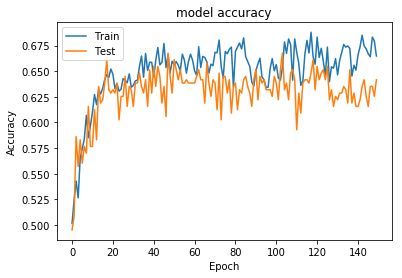

In [51]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
# from tensorflow.keras.regularizers import L1L2

model = Sequential()
model.add(Dense(1024, activation = 'relu', input_dim = x_train.shape[1]))
model.add(Dropout(0.50))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.50))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.50))
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.50))
model.add(Dense(2, activation = 'softmax'))


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
history = model.fit(x_train, y_train, epochs=150, validation_data=(x_val, y_val), verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Train and Test the model

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 1024)              2360320   
_________________________________________________________________
dropout_74 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_111 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_75 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_76 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 256)             

2760/2760 [==============================] - 0s 115us/sample - loss: 0.6935 - accuracy: 0.5018 - val_loss: 0.6927 - val_accuracy: 0.5147
Epoch 41/150
2760/2760 [==============================] - 0s 112us/sample - loss: 0.6930 - accuracy: 0.4870 - val_loss: 0.6924 - val_accuracy: 0.5114
Epoch 42/150
2760/2760 [==============================] - 0s 116us/sample - loss: 0.6951 - accuracy: 0.5000 - val_loss: 0.6919 - val_accuracy: 0.5147
Epoch 43/150
2760/2760 [==============================] - 0s 112us/sample - loss: 0.6923 - accuracy: 0.5156 - val_loss: 0.6918 - val_accuracy: 0.5049
Epoch 44/150
2760/2760 [==============================] - 0s 119us/sample - loss: 0.6927 - accuracy: 0.4942 - val_loss: 0.6915 - val_accuracy: 0.5147
Epoch 45/150
2760/2760 [==============================] - 0s 116us/sample - loss: 0.6930 - accuracy: 0.5033 - val_loss: 0.6941 - val_accuracy: 0.5114
Epoch 46/150
2760/2760 [==============================] - 0s 118us/sample - loss: 0.6928 - accuracy: 0.5127 - val

Epoch 95/150
2760/2760 [==============================] - 0s 115us/sample - loss: 0.6922 - accuracy: 0.5210 - val_loss: 0.6916 - val_accuracy: 0.5147
Epoch 96/150
2760/2760 [==============================] - 0s 113us/sample - loss: 0.6921 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4886
Epoch 97/150
2760/2760 [==============================] - 0s 115us/sample - loss: 0.6919 - accuracy: 0.5112 - val_loss: 0.6912 - val_accuracy: 0.5147
Epoch 98/150
2760/2760 [==============================] - 0s 119us/sample - loss: 0.6925 - accuracy: 0.4953 - val_loss: 0.6912 - val_accuracy: 0.5147
Epoch 99/150
2760/2760 [==============================] - 0s 113us/sample - loss: 0.6928 - accuracy: 0.4996 - val_loss: 0.6911 - val_accuracy: 0.5114
Epoch 100/150
2760/2760 [==============================] - 0s 114us/sample - loss: 0.6904 - accuracy: 0.5109 - val_loss: 0.6909 - val_accuracy: 0.5114
Epoch 101/150
2760/2760 [==============================] - 0s 114us/sample - loss: 0.6926 - accurac

2760/2760 [==============================] - 0s 114us/sample - loss: 0.6920 - accuracy: 0.4862 - val_loss: 0.6927 - val_accuracy: 0.5147
Epoch 150/150
2760/2760 [==============================] - 0s 112us/sample - loss: 0.6917 - accuracy: 0.4982 - val_loss: 0.6929 - val_accuracy: 0.5147


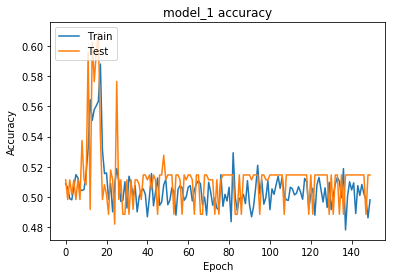

In [122]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
# from tensorflow.keras.regularizers import L1L2

model_1 = Sequential()
model_1.add(Dense(1024, activation = 'relu', input_dim = x_train_1.shape[1]))
model_1.add(Dropout(0.50))
model_1.add(Dense(512, activation = 'relu'))
model_1.add(Dropout(0.50))
model_1.add(Dense(512, activation = 'relu'))
model_1.add(Dropout(0.50))
model_1.add(Dense(256, activation = 'relu'))
model_1.add(Dense(512, activation = 'relu'))
model_1.add(Dropout(0.50))
model_1.add(Dense(512, activation = 'relu'))
model_1.add(Dropout(0.50))
model_1.add(Dense(1024, activation = 'relu'))
model_1.add(Dropout(0.50))
model_1.add(Dense(2, activation = 'softmax'))


model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_1.summary()
history = model_1.fit(x_train_1, y_train_1, epochs=150, validation_data=(x_val_1, y_val_1), verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 1024)              1573888   
_________________________________________________________________
dropout_48 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_73 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_49 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_75 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_50 (Dropout)         (None, 512)             

2760/2760 [==============================] - 0s 109us/sample - loss: 0.6144 - accuracy: 0.6525 - val_loss: 0.6277 - val_accuracy: 0.6221
Epoch 45/150
2760/2760 [==============================] - 0s 111us/sample - loss: 0.6177 - accuracy: 0.6391 - val_loss: 0.6303 - val_accuracy: 0.6287
Epoch 46/150
2760/2760 [==============================] - 0s 104us/sample - loss: 0.6075 - accuracy: 0.6543 - val_loss: 0.6449 - val_accuracy: 0.6026
Epoch 47/150
2760/2760 [==============================] - 0s 103us/sample - loss: 0.6154 - accuracy: 0.6424 - val_loss: 0.6475 - val_accuracy: 0.5993
Epoch 48/150
2760/2760 [==============================] - 0s 104us/sample - loss: 0.6188 - accuracy: 0.6435 - val_loss: 0.6329 - val_accuracy: 0.6091
Epoch 49/150
2760/2760 [==============================] - 0s 102us/sample - loss: 0.6123 - accuracy: 0.6431 - val_loss: 0.6374 - val_accuracy: 0.6254
Epoch 50/150
2760/2760 [==============================] - 0s 107us/sample - loss: 0.6059 - accuracy: 0.6580 - val

Epoch 99/150
2760/2760 [==============================] - 0s 107us/sample - loss: 0.5773 - accuracy: 0.6859 - val_loss: 0.6840 - val_accuracy: 0.6384
Epoch 100/150
2760/2760 [==============================] - 0s 111us/sample - loss: 0.6050 - accuracy: 0.6587 - val_loss: 0.6999 - val_accuracy: 0.6221
Epoch 101/150
2760/2760 [==============================] - 0s 105us/sample - loss: 0.5986 - accuracy: 0.6678 - val_loss: 0.6982 - val_accuracy: 0.5961
Epoch 102/150
2760/2760 [==============================] - 0s 109us/sample - loss: 0.5908 - accuracy: 0.6659 - val_loss: 0.6984 - val_accuracy: 0.6189
Epoch 103/150
2760/2760 [==============================] - 0s 108us/sample - loss: 0.5948 - accuracy: 0.6620 - val_loss: 0.6592 - val_accuracy: 0.6124
Epoch 104/150
2760/2760 [==============================] - 0s 106us/sample - loss: 0.6080 - accuracy: 0.6435 - val_loss: 0.6672 - val_accuracy: 0.6091
Epoch 105/150
2760/2760 [==============================] - 0s 106us/sample - loss: 0.6075 - acc

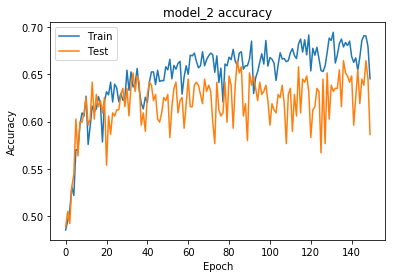

In [102]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
# from tensorflow.keras.regularizers import L1L2

model_2 = Sequential()
model_2.add(Dense(1024, activation = 'relu', input_dim = x_train_2.shape[1]))
model_2.add(Dropout(0.50))
model_2.add(Dense(512, activation = 'relu'))
model_2.add(Dropout(0.50))
model_2.add(Dense(256, activation = 'relu'))
model_2.add(Dense(512, activation = 'relu'))
model_2.add(Dropout(0.50))
model_2.add(Dense(1024, activation = 'relu'))
model_2.add(Dropout(0.50))
model_2.add(Dense(2, activation = 'softmax'))


model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_2.summary()
history = model_2.fit(x_train_2, y_train_2, epochs=150, validation_data=(x_val_2, y_val_2), verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 1024)              1573888   
_________________________________________________________________
dropout_52 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_79 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_53 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_81 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_54 (Dropout)         (None, 512)             

2760/2760 [==============================] - 0s 110us/sample - loss: 0.6378 - accuracy: 0.6199 - val_loss: 0.6337 - val_accuracy: 0.6450
Epoch 45/150
2760/2760 [==============================] - 0s 108us/sample - loss: 0.6374 - accuracy: 0.6178 - val_loss: 0.6245 - val_accuracy: 0.6580
Epoch 46/150
2760/2760 [==============================] - 0s 107us/sample - loss: 0.6221 - accuracy: 0.6337 - val_loss: 0.6187 - val_accuracy: 0.6384
Epoch 47/150
2760/2760 [==============================] - 0s 111us/sample - loss: 0.6159 - accuracy: 0.6453 - val_loss: 0.6112 - val_accuracy: 0.6580
Epoch 48/150
2760/2760 [==============================] - 0s 110us/sample - loss: 0.5954 - accuracy: 0.6674 - val_loss: 0.6332 - val_accuracy: 0.6515
Epoch 49/150
2760/2760 [==============================] - 0s 110us/sample - loss: 0.6105 - accuracy: 0.6576 - val_loss: 0.6148 - val_accuracy: 0.6580
Epoch 50/150
2760/2760 [==============================] - 0s 103us/sample - loss: 0.6140 - accuracy: 0.6482 - val

Epoch 99/150
2760/2760 [==============================] - 0s 110us/sample - loss: 0.5944 - accuracy: 0.6630 - val_loss: 0.6085 - val_accuracy: 0.6743
Epoch 100/150
2760/2760 [==============================] - 0s 104us/sample - loss: 0.6033 - accuracy: 0.6536 - val_loss: 0.5951 - val_accuracy: 0.6775
Epoch 101/150
2760/2760 [==============================] - 0s 110us/sample - loss: 0.6038 - accuracy: 0.6565 - val_loss: 0.6054 - val_accuracy: 0.6710
Epoch 102/150
2760/2760 [==============================] - 0s 107us/sample - loss: 0.5968 - accuracy: 0.6678 - val_loss: 0.6040 - val_accuracy: 0.6743
Epoch 103/150
2760/2760 [==============================] - 0s 109us/sample - loss: 0.6027 - accuracy: 0.6551 - val_loss: 0.5979 - val_accuracy: 0.6775
Epoch 104/150
2760/2760 [==============================] - 0s 103us/sample - loss: 0.5950 - accuracy: 0.6634 - val_loss: 0.6100 - val_accuracy: 0.6612
Epoch 105/150
2760/2760 [==============================] - 0s 105us/sample - loss: 0.6052 - acc

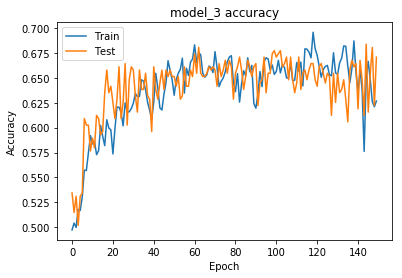

In [103]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
# from tensorflow.keras.regularizers import L1L2

model_3 = Sequential()
model_3.add(Dense(1024, activation = 'relu', input_dim = x_train_3.shape[1]))
model_3.add(Dropout(0.50))
model_3.add(Dense(512, activation = 'relu'))
model_3.add(Dropout(0.50))
model_3.add(Dense(256, activation = 'relu'))
model_3.add(Dense(512, activation = 'relu'))
model_3.add(Dropout(0.50))
model_3.add(Dense(1024, activation = 'relu'))
model_3.add(Dropout(0.50))
model_3.add(Dense(2, activation = 'softmax'))


model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_3.summary()
history = model_3.fit(x_train_3, y_train_3, epochs=150, validation_data=(x_val_3, y_val_3), verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 1024)              1573888   
_________________________________________________________________
dropout_56 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_85 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_57 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_87 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_58 (Dropout)         (None, 512)             

2760/2760 [==============================] - 0s 106us/sample - loss: 0.6119 - accuracy: 0.6634 - val_loss: 0.5987 - val_accuracy: 0.6547
Epoch 45/150
2760/2760 [==============================] - 0s 106us/sample - loss: 0.6160 - accuracy: 0.6471 - val_loss: 0.6072 - val_accuracy: 0.6482
Epoch 46/150
2760/2760 [==============================] - 0s 105us/sample - loss: 0.6186 - accuracy: 0.6446 - val_loss: 0.6173 - val_accuracy: 0.6580
Epoch 47/150
2760/2760 [==============================] - 0s 108us/sample - loss: 0.6122 - accuracy: 0.6616 - val_loss: 0.6022 - val_accuracy: 0.6482
Epoch 48/150
2760/2760 [==============================] - 0s 104us/sample - loss: 0.6143 - accuracy: 0.6471 - val_loss: 0.6109 - val_accuracy: 0.6384
Epoch 49/150
2760/2760 [==============================] - 0s 105us/sample - loss: 0.6138 - accuracy: 0.6580 - val_loss: 0.6261 - val_accuracy: 0.6417
Epoch 50/150
2760/2760 [==============================] - 0s 107us/sample - loss: 0.6028 - accuracy: 0.6739 - val

Epoch 99/150
2760/2760 [==============================] - 0s 105us/sample - loss: 0.5910 - accuracy: 0.6822 - val_loss: 0.6174 - val_accuracy: 0.6450
Epoch 100/150
2760/2760 [==============================] - 0s 107us/sample - loss: 0.5844 - accuracy: 0.6775 - val_loss: 0.6054 - val_accuracy: 0.6515
Epoch 101/150
2760/2760 [==============================] - 0s 107us/sample - loss: 0.5995 - accuracy: 0.6833 - val_loss: 0.6130 - val_accuracy: 0.6352
Epoch 102/150
2760/2760 [==============================] - 0s 105us/sample - loss: 0.5919 - accuracy: 0.6830 - val_loss: 0.6077 - val_accuracy: 0.6482
Epoch 103/150
2760/2760 [==============================] - 0s 105us/sample - loss: 0.5835 - accuracy: 0.6928 - val_loss: 0.6064 - val_accuracy: 0.6612
Epoch 104/150
2760/2760 [==============================] - 0s 108us/sample - loss: 0.5920 - accuracy: 0.6822 - val_loss: 0.6127 - val_accuracy: 0.6352
Epoch 105/150
2760/2760 [==============================] - 0s 109us/sample - loss: 0.5935 - acc

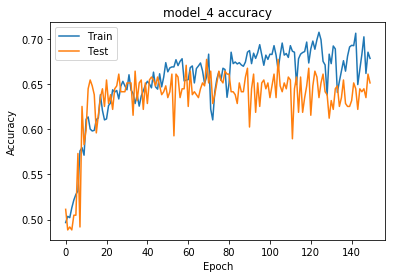

In [104]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
# from tensorflow.keras.regularizers import L1L2

model_4 = Sequential()
model_4.add(Dense(1024, activation = 'relu', input_dim = x_train_4.shape[1]))
model_4.add(Dropout(0.50))
model_4.add(Dense(512, activation = 'relu'))
model_4.add(Dropout(0.50))
model_4.add(Dense(256, activation = 'relu'))
model_4.add(Dense(512, activation = 'relu'))
model_4.add(Dropout(0.50))
model_4.add(Dense(1024, activation = 'relu'))
model_4.add(Dropout(0.50))
model_4.add(Dense(2, activation = 'softmax'))


model_4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_4.summary()
history = model_4.fit(x_train_4, y_train_4, epochs=150, validation_data=(x_val_4, y_val_4), verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_4 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 1024)              1573888   
_________________________________________________________________
dropout_60 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_91 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_61 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_93 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_62 (Dropout)         (None, 512)             

2760/2760 [==============================] - 0s 100us/sample - loss: 0.5799 - accuracy: 0.6601 - val_loss: 0.5879 - val_accuracy: 0.6580
Epoch 45/150
2760/2760 [==============================] - 0s 103us/sample - loss: 0.6007 - accuracy: 0.6402 - val_loss: 0.6043 - val_accuracy: 0.6808
Epoch 46/150
2760/2760 [==============================] - 0s 104us/sample - loss: 0.5901 - accuracy: 0.6576 - val_loss: 0.5938 - val_accuracy: 0.6580
Epoch 47/150
2760/2760 [==============================] - 0s 102us/sample - loss: 0.6092 - accuracy: 0.6308 - val_loss: 0.6163 - val_accuracy: 0.6384
Epoch 48/150
2760/2760 [==============================] - 0s 102us/sample - loss: 0.6022 - accuracy: 0.6591 - val_loss: 0.5928 - val_accuracy: 0.6808
Epoch 49/150
2760/2760 [==============================] - 0s 104us/sample - loss: 0.5960 - accuracy: 0.6514 - val_loss: 0.6061 - val_accuracy: 0.6091
Epoch 50/150
2760/2760 [==============================] - 0s 100us/sample - loss: 0.5798 - accuracy: 0.6489 - val

Epoch 99/150
2760/2760 [==============================] - 0s 103us/sample - loss: 0.5859 - accuracy: 0.6761 - val_loss: 0.6088 - val_accuracy: 0.6580
Epoch 100/150
2760/2760 [==============================] - 0s 103us/sample - loss: 0.5818 - accuracy: 0.6790 - val_loss: 0.6444 - val_accuracy: 0.6645
Epoch 101/150
2760/2760 [==============================] - 0s 104us/sample - loss: 0.6021 - accuracy: 0.6471 - val_loss: 0.6019 - val_accuracy: 0.6645
Epoch 102/150
2760/2760 [==============================] - 0s 101us/sample - loss: 0.5823 - accuracy: 0.6649 - val_loss: 0.6077 - val_accuracy: 0.6352
Epoch 103/150
2760/2760 [==============================] - 0s 102us/sample - loss: 0.5592 - accuracy: 0.6743 - val_loss: 0.6166 - val_accuracy: 0.6319
Epoch 104/150
2760/2760 [==============================] - 0s 104us/sample - loss: 0.5816 - accuracy: 0.6721 - val_loss: 0.6167 - val_accuracy: 0.6515
Epoch 105/150
2760/2760 [==============================] - 0s 103us/sample - loss: 0.5766 - acc

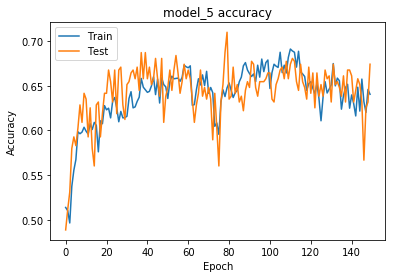

In [105]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
# from tensorflow.keras.regularizers import L1L2

model_5 = Sequential()
model_5.add(Dense(1024, activation = 'relu', input_dim = x_train_5.shape[1]))
model_5.add(Dropout(0.50))
model_5.add(Dense(512, activation = 'relu'))
model_5.add(Dropout(0.50))
model_5.add(Dense(256, activation = 'relu'))
model_5.add(Dense(512, activation = 'relu'))
model_5.add(Dropout(0.50))
model_5.add(Dense(1024, activation = 'relu'))
model_5.add(Dropout(0.50))
model_5.add(Dense(2, activation = 'softmax'))


model_5.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_5.summary()
history = model_5.fit(x_train_5, y_train_5, epochs=150, validation_data=(x_val_5, y_val_5), verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_5 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [84]:
y_pred_1 = model_1.predict(x_test_1)
y_pred__1 = np.array([np.argmax(i) for i in y_pred_1])

In [85]:
y_pred_2 = model_2.predict(x_test_1)
y_pred__2 = np.array([np.argmax(i) for i in y_pred_2])

In [86]:
y_pred_3 = model_3.predict(x_test_1)
y_pred__3 = np.array([np.argmax(i) for i in y_pred_3])

In [87]:
y_pred_4 = model_4.predict(x_test_1)
y_pred__4 = np.array([np.argmax(i) for i in y_pred_4])

In [88]:
y_pred_5 = model_5.predict(x_test_1)
y_pred__5 = np.array([np.argmax(i) for i in y_pred_5])

In [83]:
y_pred_ = (y_pred__1 + y_pred__2 + y_pred__3 + y_pred__4 + y_pred__5)

In [52]:
y_pred_ = model.predict(x_test)
y_pred__ = np.array([np.argmax(i) for i in y_pred_])

In [110]:
model_1_json = model_1.to_json() 
with open("model_1.json", "w") as json_file:
    json_file.write(model_1_json)
    model_1.save_weights("model_1.h5")
model_2_json = model_2.to_json()
with open("model_2.json", "w") as json_file:
    json_file.write(model_2_json)
    model_2.save_weights("model_2.h5")
model_3_json = model_3.to_json()
with open("model_3.json", "w") as json_file:
    json_file.write(model_3_json)
    model_3.save_weights("model_3.h5")
model_4_json = model_4.to_json()
with open("model_4.json", "w") as json_file:
    json_file.write(model_4_json)
    model_4.save_weights("model_4.h5")
model_5_json = model_5.to_json()
with open("model_5.json", "w") as json_file:
    json_file.write(model_5_json)
    model_5.save_weights("model_5.h5")
model_1.save("final_model_1.h5")
model_2.save("final_model_2.h5")
model_3.save("final_model_3.h5")
model_4.save("final_model_4.h5")
model_5.save("final_model_5.h5")

In [53]:
def get_scores(y_pred, y_test):
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
    accuracy = accuracy_score(y_pred, y_test)
    cm = confusion_matrix(y_pred, y_test)
    precision = precision_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    recall = recall_score(y_pred, y_test)

    print("Test Accuracy: ", accuracy)
    print("Test Confusion Matrix: \n", cm)
    print("Test Precision: ", precision)
    print("Test Recall :", recall)
    print("Test f1: ", f1)

get_scores(y_pred__, y_test)

Test Accuracy:  0.6727509778357236
Test Confusion Matrix: 
 [[306 156]
 [ 95 210]]
Test Precision:  0.5737704918032787
Test Recall : 0.6885245901639344
Test f1:  0.6259314456035767


In [36]:
from sklearn.svm import SVC
svc_model = SVC(gamma='auto')
svc_model.fit(x_train, y_train)

y_pred = svc_model.predict(x_test)
get_scores(y_pred, y_test)

Test Accuracy:  0.6179921773142112
Test Confusion Matrix: 
 [[276 168]
 [125 198]]
Test Precision:  0.5409836065573771
Test Recall : 0.6130030959752322
Test f1:  0.574746008708273


In [89]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(x_train_2, y_train_2)

y_pred__6 = nb_model.predict(x_test_1)
#get_scores((y_pred_+y_pred)/2, y_test_1)
from scipy import stats
m = stats.mode(np.array([y_pred__6,y_pred__3,y_pred__4]))
y_pred_ = m[0][0]
get_scores(y_pred_, y_test_1)

Test Accuracy:  0.6388526727509778
Test Confusion Matrix: 
 [[381 257]
 [ 20 109]]
Test Precision:  0.2978142076502732
Test Recall : 0.8449612403100775
Test f1:  0.4404040404040404


In [12]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)

y_pred = nb_model.predict(x_test)
get_scores(y_pred, y_test)

ValueError: Input X must be non-negative

In [38]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)

y_pred = knn_model.predict(x_test)
get_scores(y_pred, y_test)

Test Accuracy:  0.6284224250325945
Test Confusion Matrix: 
 [[288 172]
 [113 194]]
Test Precision:  0.5300546448087432
Test Recall : 0.6319218241042345
Test f1:  0.5765230312035661


In [2]:
AFTER_CANCER_PATH = "/home/chennuri/CliNER/aft_canc_mod/"
BEFORE_CANCER_PATH = "/home/chennuri/CliNER/bef_canc_mod/"
NO_CANCER_PATH = "/home/chennuri/CliNER/no_canc_mod/"

X_bef_problems_files = os.listdir(BEFORE_CANCER_PATH)
X_no_problems_files = os.listdir(NO_CANCER_PATH)

X_before_cancer_problems1 = np.array([open(BEFORE_CANCER_PATH + file, 'r').readlines() for file in X_bef_problems_files])
X_no_cancer_problems_11 = np.array([open(NO_CANCER_PATH + file, 'r').read() for file in X_no_problems_files])[:X_before_cancer_problems1.shape[0]]

In [3]:
BIO_BERT_PATH = '/home/gowtham/biobert_v1.1_pubmed'
doc_emb = np.zeros((X_before_cancer_problems1.shape[0],768))
for i in range(len(X_bef_problems_files)):
    os.system("python3 /home/girish/Cancer-Prognosis-using-NLP/embed.py --inputfile="+BEFORE_CANCER_PATH+X_bef_problems_files[i])
    temp_emb = np.load("outfile.npy")
    sent_emb = np.zeros((len(temp_emb),768))
    for j in range(len(temp_emb)):
        sent_emb[j] = np.mean(temp_emb[j],axis=0).squeeze()
    doc_emb[i] = np.mean(sent_emb,axis=0).squeeze()
    print("Document: ",i+1)

Document:  1
Document:  2
Document:  3
Document:  4
Document:  5
Document:  6
Document:  7
Document:  8
Document:  9
Document:  10
Document:  11
Document:  12
Document:  13
Document:  14
Document:  15
Document:  16
Document:  17
Document:  18
Document:  19
Document:  20
Document:  21
Document:  22
Document:  23
Document:  24
Document:  25
Document:  26
Document:  27
Document:  28
Document:  29
Document:  30
Document:  31
Document:  32
Document:  33
Document:  34
Document:  35
Document:  36
Document:  37
Document:  38
Document:  39
Document:  40
Document:  41
Document:  42
Document:  43
Document:  44
Document:  45
Document:  46
Document:  47


/usr/local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Document:  48
Document:  49
Document:  50
Document:  51
Document:  52
Document:  53
Document:  54
Document:  55
Document:  56
Document:  57
Document:  58
Document:  59
Document:  60
Document:  61
Document:  62
Document:  63
Document:  64
Document:  65
Document:  66
Document:  67
Document:  68
Document:  69
Document:  70
Document:  71
Document:  72
Document:  73
Document:  74
Document:  75
Document:  76
Document:  77
Document:  78
Document:  79
Document:  80
Document:  81
Document:  82
Document:  83
Document:  84
Document:  85
Document:  86
Document:  87
Document:  88
Document:  89
Document:  90
Document:  91
Document:  92
Document:  93
Document:  94
Document:  95
Document:  96
Document:  97
Document:  98
Document:  99
Document:  100
Document:  101
Document:  102
Document:  103
Document:  104
Document:  105
Document:  106
Document:  107
Document:  108
Document:  109
Document:  110
Document:  111
Document:  112
Document:  113
Document:  114
Document:  115
Document:  116
Document:  117
Do

Document:  598
Document:  599
Document:  600
Document:  601
Document:  602
Document:  603
Document:  604
Document:  605
Document:  606
Document:  607
Document:  608
Document:  609
Document:  610
Document:  611
Document:  612
Document:  613
Document:  614
Document:  615
Document:  616
Document:  617
Document:  618
Document:  619
Document:  620
Document:  621
Document:  622
Document:  623
Document:  624
Document:  625
Document:  626
Document:  627
Document:  628
Document:  629
Document:  630
Document:  631
Document:  632
Document:  633
Document:  634
Document:  635
Document:  636
Document:  637
Document:  638
Document:  639
Document:  640
Document:  641
Document:  642
Document:  643
Document:  644
Document:  645
Document:  646
Document:  647
Document:  648
Document:  649
Document:  650
Document:  651
Document:  652
Document:  653
Document:  654
Document:  655
Document:  656
Document:  657
Document:  658
Document:  659
Document:  660
Document:  661
Document:  662
Document:  663
Document: 

Document:  1136
Document:  1137
Document:  1138
Document:  1139
Document:  1140
Document:  1141
Document:  1142
Document:  1143
Document:  1144
Document:  1145
Document:  1146
Document:  1147
Document:  1148
Document:  1149
Document:  1150
Document:  1151
Document:  1152
Document:  1153
Document:  1154
Document:  1155
Document:  1156
Document:  1157
Document:  1158
Document:  1159
Document:  1160
Document:  1161
Document:  1162
Document:  1163
Document:  1164
Document:  1165
Document:  1166
Document:  1167
Document:  1168
Document:  1169
Document:  1170
Document:  1171
Document:  1172
Document:  1173
Document:  1174
Document:  1175
Document:  1176
Document:  1177
Document:  1178
Document:  1179
Document:  1180
Document:  1181
Document:  1182
Document:  1183
Document:  1184
Document:  1185
Document:  1186
Document:  1187
Document:  1188
Document:  1189
Document:  1190
Document:  1191
Document:  1192
Document:  1193
Document:  1194
Document:  1195
Document:  1196
Document:  1197
Document

Document:  1649
Document:  1650
Document:  1651
Document:  1652
Document:  1653
Document:  1654
Document:  1655
Document:  1656
Document:  1657
Document:  1658
Document:  1659
Document:  1660
Document:  1661
Document:  1662
Document:  1663
Document:  1664
Document:  1665
Document:  1666
Document:  1667
Document:  1668
Document:  1669
Document:  1670
Document:  1671
Document:  1672
Document:  1673
Document:  1674
Document:  1675
Document:  1676
Document:  1677
Document:  1678
Document:  1679
Document:  1680
Document:  1681
Document:  1682
Document:  1683
Document:  1684
Document:  1685
Document:  1686
Document:  1687
Document:  1688
Document:  1689
Document:  1690
Document:  1691
Document:  1692
Document:  1693
Document:  1694
Document:  1695
Document:  1696
Document:  1697
Document:  1698
Document:  1699
Document:  1700
Document:  1701
Document:  1702
Document:  1703
Document:  1704
Document:  1705
Document:  1706
Document:  1707
Document:  1708
Document:  1709
Document:  1710
Document

In [ ]:
doc_emb2 = np.zeros((X_no_cancer_problems_11.shape[0],768))
for i in range(len(X_bef_problems_files)):
    os.system("python3 /home/girish/Cancer-Prognosis-using-NLP/embed.py --inputfile="+NO_CANCER_PATH+X_no_problems_files[i])
    temp_emb = np.load("outfile.npy")
    sent_emb = np.zeros((len(temp_emb),768))
    for j in range(len(temp_emb)):
        sent_emb[j] = np.mean(temp_emb[j],axis=0).squeeze()
    doc_emb2[i] = np.mean(sent_emb,axis=0).squeeze()
    print("Document: ",i+1)

Document:  1
Document:  2
Document:  3
Document:  4
Document:  5
Document:  6
Document:  7
Document:  8
Document:  9
Document:  10
Document:  11
Document:  12
Document:  13
Document:  14
Document:  15
Document:  16
Document:  17
Document:  18
Document:  19
Document:  20
Document:  21
Document:  22
Document:  23
Document:  24
Document:  25
Document:  26
Document:  27
Document:  28
Document:  29
Document:  30
Document:  31
Document:  32
Document:  33
Document:  34
Document:  35
Document:  36
Document:  37
Document:  38
Document:  39
Document:  40
Document:  41
Document:  42
Document:  43
Document:  44
Document:  45
Document:  46
Document:  47
Document:  48
Document:  49
Document:  50
Document:  51
Document:  52
Document:  53
Document:  54
Document:  55
Document:  56
Document:  57
Document:  58
Document:  59
Document:  60
Document:  61


In [5]:
from tempfile import TemporaryFile

outfile_bef = TemporaryFile()
outfile_no = TemporaryFile()
np.save("outfile_bef",doc_emb)
np.save("outfile_no",doc_emb2)